<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Masked_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.models as tfkm
import tensorflow.keras.layers as tfkl
import tensorflow.keras.utils as tfku

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.cifar100.load_data()

In [4]:
class RegressionTransformer(tfkm.Model):
    def __init__(self, **kwds):
        inp_context_len = kwds['inp_context_len']
        out_context_len = kwds['out_context_len']
        num_input = kwds['num_input']
        num_output = kwds['num_output']
        encoding_len = kwds['encoding_len']
        ff_hidden = kwds['ff_hidden']
        num_encoders = kwds['num_encoders']
        num_decoders = kwds['num_decoders']
        encoder_num_heads = kwds['encoder_num_heads']
        encoder_key_dim = kwds['encoder_key_dim']
        decoder_num_heads = kwds['decoder_num_heads']
        decoder_key_dim = kwds['decoder_key_dim']
        max_pos_idx = kwds['max_pos_idx']
        pos_enc_arr = kwds['pos_enc']

        inp = tfkl.Input([inp_context_len, num_input])
        out = tfkl.Input([out_context_len, num_output])

        inp_pos = tfkl.Input([inp_context_len])
        out_pos = tfkl.Input([out_context_len])

        position_encoding = tfkl.Embedding(input_dim = max_pos_idx, output_dim = encoding_len)
        position_encoding.trainable = False


        inp_pos_enc = position_encoding(inp_pos)
        out_pos_enc = position_encoding(out_pos)

        position_encoding.set_weights([pos_enc_arr])


        x = inp
        x = tfkl.Dense(encoding_len)(x)
        x = tfkl.Add()([x, inp_pos_enc])

        #encoder block

        for _ in range(num_encoders):
            #self attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = encoder_num_heads, key_dim = encoder_key_dim)(x, x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #feed forward
            res = x
            x = tfkl.Dense(ff_hidden)(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(encoding_len)(x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

        encoding = x

        #decoder block

        x = out
        x = tfkl.Dense(encoding_len)(x)
        x = tfkl.Add()([x, out_pos_enc])

        for _ in range(num_decoders):
            #self attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = decoder_num_heads, key_dim = decoder_key_dim)(x, x, use_causal_mask = True)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #cross attention subblock
            res = x
            x = tfkl.MultiHeadAttention(num_heads = decoder_num_heads, key_dim = decoder_key_dim)(x, encoding)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)

            #feed forward
            res = x
            x = tfkl.Dense(ff_hidden)(x)
            x = tfkl.BatchNormalization()(x)
            x = tfkl.Activation('gelu')(x)
            x = tfkl.Dense(encoding_len)(x)
            x = tfkl.Add()([x, res])
            x = tfkl.LayerNormalization()(x)


        x = tfkl.Dense(num_output)(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.Activation('tanh')(x)
        pred = x

        super(RegressionTransformer, self).__init__(inputs = [inp, inp_pos, out, out_pos], outputs = [pred])

In [5]:
def get_position_encoding(num):
    pos_enc_df = pd.DataFrame({'t': np.arange(2**num)})

    for idx in range(num):
        pos_enc_df.eval(f's{idx} = sin({2 ** idx} * {np.pi/2} * t / {2 ** num})', inplace = True)
        pos_enc_df.eval(f'c{idx} = cos({2 ** idx} * {np.pi/2} * t / {2 ** num})', inplace = True)

    pos_enc_df.drop('t', axis = 1, inplace = True)

    return pos_enc_df.values

In [6]:
pos_enc = get_position_encoding(11)

In [7]:
pos_enc.shape

(2048, 22)

<Axes: >

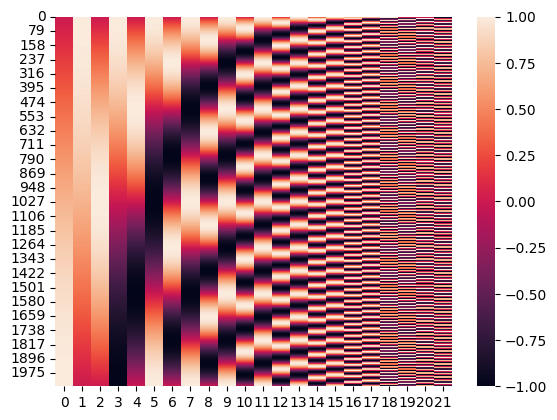

In [8]:
sns.heatmap(pos_enc)

In [9]:
model = RegressionTransformer(
    inp_context_len = 512,
    out_context_len = 1023,
    num_input = 3,
    num_output = 3,
    encoding_len = 22,
    ff_hidden = 8,
    num_encoders = 8,
    num_decoders = 4,
    encoder_num_heads = 4,
    encoder_key_dim = 3,
    decoder_num_heads = 3,
    decoder_key_dim = 2,
    max_pos_idx = 2048,
    pos_enc = pos_enc
)

In [10]:
model.compile(
    optimizer = tf.keras.optimizers.AdamW(),
    loss = tf.keras.losses.MeanSquaredError()
)

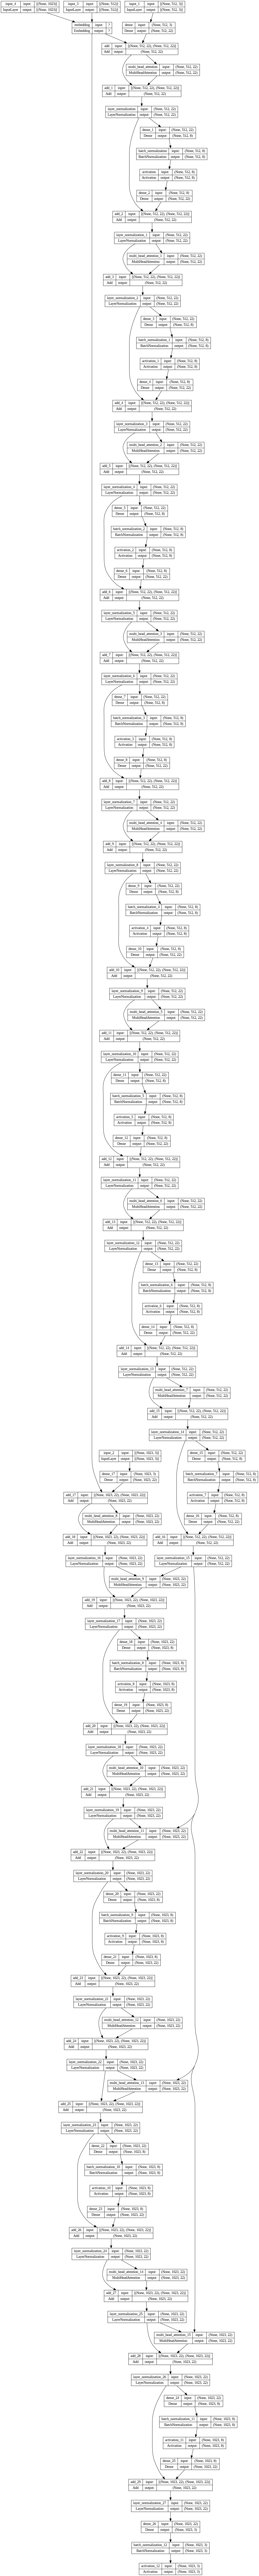

In [11]:
tfku.plot_model(model, show_shapes = True)

In [12]:
model.summary()

Model: "regression_transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1023)]               0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 512, 3)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     45056     ['input_3[0][0]',             
                                                                     'input_4

In [13]:
def preprocess_input(x):
    input_shape = tf.shape(x)
    new_size = input_shape[-3] * input_shape[-2]
    mask_size = tf.cast(new_size/2, dtype = tf.int32)
    flatten_x =  tf.reshape(x, [new_size, input_shape[-1]])

    norm_flatten_x = tf.cast(flatten_x, dtype = tf.float32)/127.5 - 1

    decoder_input = norm_flatten_x[:-1, :]
    decoder_output = norm_flatten_x[1:, :]

    inp_pos = tf.range(new_size)
    out_pos = tf.range(new_size - 1)

    temp = tf.random.uniform([new_size])
    temp = tf.squeeze(temp)
    temp = tf.argsort(temp)
    temp = temp[:mask_size]
    temp = tf.sort(temp)
    mask_pos = temp

    masked_input = tf.gather(norm_flatten_x, indices = mask_pos, axis = -2)

    return (masked_input, mask_pos, decoder_input, out_pos), decoder_output

In [14]:
def train_fn(x, batch_size):
    dataset = (
        tf.data.Dataset.from_tensor_slices(x)
                      .map(preprocess_input)
                      .shuffle(buffer_size = 10 * batch_size)
                      .batch(batch_size)
    )

    model.fit(dataset)

In [15]:
train_fn(x_train, 30)

1667/1667 [==============================] - 830s 456ms/step - loss: 0.0539
